In [1]:
import pandas as pd
import numpy as np
import sklearn
import random, os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from fairness_evals import positive_rates, true_postive_rates, true_negative_rate, false_postive_rates

# Data

In [2]:
data_old = pd.read_csv(os.path.join('Processed_data', 'adult.csv'))

In [3]:
data_old.keys()

Index(['age', 'workclass', 'education', 'marital.status', 'race', 'sex',
       'hours.per.week', 'income'],
      dtype='object')

In [4]:
data_old

,age,workclass,education,marital.status,race,sex,hours.per.week,income
0,82,Private,HS-grad,Widowed,White,Female,18,0
1,54,Private,7th-8th,Divorced,White,Female,40,0
2,41,Private,Some-college,Separated,White,Female,40,0
3,34,Private,HS-grad,Divorced,White,Female,45,0
4,38,Private,10th,Separated,White,Male,40,0
...,...,...,...,...,...,...,...,...
30157,22,Private,Some-college,Never-married,White,Male,40,0
30158,27,Private,Assoc,Married,White,Female,38,0
30159,40,Private,HS-grad,Married,White,Male,40,1
30160,58,Private,HS-grad,Widowed,White,Female,40,0


In [5]:
data_2018 = pd.read_csv(os.path.join('Processed_data', 'data_2018.csv'))

In [6]:
data_2018.keys()

Index(['age', 'workclass', 'education', 'marital.status', 'hours.per.week',
       'sex', 'race', 'income'],
      dtype='object')

In [7]:
data_2018

,age,workclass,education,marital.status,hours.per.week,sex,race,income
0,18,Private,Some-college,Never-married,21,Female,Black,0
1,53,Federal-gov,HS-grad,Never-married,40,Male,White,0
2,41,Private,HS-grad,Never-married,40,Male,White,0
3,18,Self-emp-not-inc,Some-college,Never-married,2,Female,White,0
4,21,Federal-gov,Some-college,Never-married,50,Male,White,0
...,...,...,...,...,...,...,...,...
1667190,39,Self-emp-not-inc,HS-grad,Never-married,20,Male,White,0
1667191,38,Self-emp-not-inc,11th,Never-married,32,Male,Other,0
1667192,37,Private,Some-college,Divorced,40,Female,Other,0
1667193,47,Private,HS-grad,Married,40,Male,Other,0


In [8]:
DATA = data_old 
# DATA.drop(columns=['occupation'])
DATA_NAME = 'old' #! don't forget to change this accordingly 
FEAT_OF_INT = ['education', 'marital.status', 'sex', 'income'] #The features we are interested in
DATA.head()

,age,workclass,education,marital.status,race,sex,hours.per.week,income
0,82,Private,HS-grad,Widowed,White,Female,18,0
1,54,Private,7th-8th,Divorced,White,Female,40,0
2,41,Private,Some-college,Separated,White,Female,40,0
3,34,Private,HS-grad,Divorced,White,Female,45,0
4,38,Private,10th,Separated,White,Male,40,0


## Encoder for categorical values

In [9]:
from sklearn.preprocessing import OneHotEncoder
cat_feats = list(DATA.select_dtypes("object").keys())  #names of all categorical features
# cat_feats.remove('income') #keep these values as is 
print(f"{len(cat_feats)} categorical features found: {cat_feats}")

cat_feat_encoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform="pandas")
cat_feat_encoder = cat_feat_encoder.fit(DATA[cat_feats])

5 categorical features found: ['workclass', 'education', 'marital.status', 'race', 'sex']


## Split train, dev and test

In [10]:
train, rest = train_test_split(DATA, test_size=0.3, random_state= 64819)
dev, test_old = train_test_split(rest, test_size=2/3, random_state= 8910)
test_2018 = data_2018
print(f"Train size: {len(train)}, dev size: {len(dev)}, test old size: {len(test_old)}, test 2018 size: {len(test_2018)}")

Train size: 21113, dev size: 3016, test old size: 6033, test 2018 size: 1667195


In [11]:
x_train = train.drop(columns=['income'])
y_train = train['income']

x_dev  = dev.drop(columns=['income'])
y_dev  = dev['income']

x_test_old  = test_old.drop(columns=['income'])
y_test_old  = test_old['income']

x_test_2018  = test_2018.drop(columns=['income'])
y_test_2018  = test_2018['income']

In [12]:
from Dataverwerking.data_transform import cat_to_one_hot
x_train_encoded = cat_to_one_hot(x_train, cat_feats, cat_feat_encoder)
x_dev_encoded = cat_to_one_hot(x_dev, cat_feats, cat_feat_encoder)
x_test_old_encoded = cat_to_one_hot(x_test_old, cat_feats, cat_feat_encoder)
x_test_2018_encoded = cat_to_one_hot(x_test_2018, cat_feats, cat_feat_encoder)


In [13]:
x_train_encoded

,age,hours.per.week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,...,education_Some-college,marital.status_Married,marital.status_Never-married,marital.status_Separated,marital.status_Widowed,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
24645,25,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
9183,33,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
7007,62,40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
13429,24,48,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
17605,23,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28199,60,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
20094,35,40,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7221,23,50,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
11128,30,50,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [14]:
x_test_2018_encoded

,age,hours.per.week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,...,education_Some-college,marital.status_Married,marital.status_Never-married,marital.status_Separated,marital.status_Widowed,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,18,21,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,53,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,41,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,18,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,21,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667190,39,20,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1667191,38,32,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1667192,37,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1667193,47,40,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


# Logistic regression

**params logreg**
* Penalty (=L2)
* C (=1): regularization strenght -> set with dev set 
* solver: ?

In [15]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver = 'lbfgs', max_iter=250, class_weight={0: 0.32, 1: 0.68}).fit(x_train_encoded, y_train)

/Users/jip/Documents/Uni_master/Human-Centered ML/HCML_project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
from collections import defaultdict
feat_weights = [np.abs(x) for x in logreg.coef_[0]]
feat_names = list(logreg.feature_names_in_)
FI = defaultdict(int)
for c, name in zip(feat_weights, feat_names):
    split_name = name.split('_')
    orig_name = split_name[0]
    # print(orig_name)
    if len(split_name) > 1:
        value_name = split_name[1]
        # print(value_name)
        importance = train[orig_name].value_counts()[value_name]/ len (train[orig_name]) * c
    else: importance = c
    FI[orig_name] += importance
print(FI)

defaultdict(<class 'int'>, {'age': 0.029967328961429594, 'hours.per.week': 0.03226832966473246, 'workclass': 0.6524619742899285, 'education': 0.7264437156634274, 'marital.status': 1.1294369583796804, 'race': 0.14673576682717754, 'sex': 0.14509247060614197})


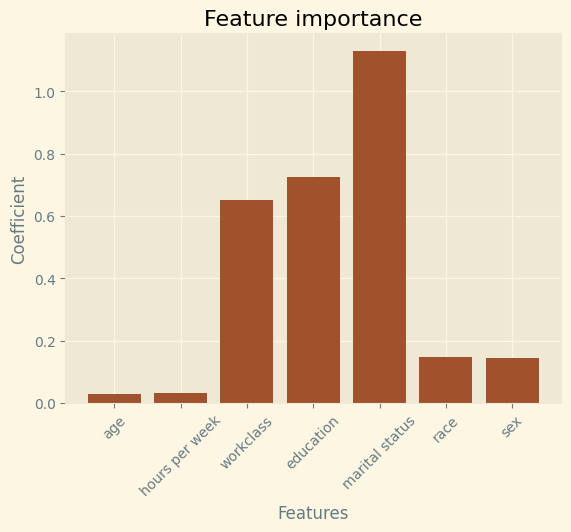

In [30]:
import matplotlib.pyplot as plt 
from matplotlib import style 
feat_weights = [np.abs(x) for x in logreg.coef_[0]]
feat_names = list(logreg.feature_names_in_)
names = [name.replace('.', ' ') for name, _ in FI.items()]
values = [value for _, value in FI.items()]
plt.bar(names, values, width=0.8, color = 'sienna')
plt.style.use('Solarize_Light2')
plt.xticks(rotation = 45)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Feature importance')
plt.savefig(os.path.join('plots', 'feature_importance'), bbox_inches='tight')
plt.show()


In [18]:
sorted_lijst = [np.abs(x) for x in logreg.coef_[0]]
sorted_lijst.sort()
best_10 =sorted_lijst[-10:]

In [19]:
for i in range (len(logreg.coef_[0])):
    if logreg.coef_[0][i] in best_10:
        print(i)

15
16
18
20
22


## Dev evaluation

In [20]:
y_pred_dev= list(logreg.predict(x_dev_encoded))

logreg_results_dev = dev.copy() #get all the data of the dev set

logreg_results_dev = logreg_results_dev.filter(items=FEAT_OF_INT) #keep only relevant info
logreg_results_dev['y_pred'] = y_pred_dev
logreg_results_dev

,education,marital.status,sex,income,y_pred
25299,Some-college,Separated,Female,0,0
938,HS-grad,Married,Male,1,1
9113,HS-grad,Never-married,Male,0,0
19694,10th,Married,Male,1,1
22532,Bachelors,Divorced,Female,0,0
...,...,...,...,...,...
12403,Bachelors,Never-married,Female,0,0
15435,12th,Widowed,Female,0,0
26831,HS-grad,Married,Male,1,0
11994,Some-college,Never-married,Male,0,0


In [21]:
logreg_acc_dev = accuracy_score(y_dev, y_pred_dev)
logreg_rec_dev = recall_score(y_dev, y_pred_dev)
logreg_pre_dev = precision_score(y_dev, y_pred_dev)
logreg_f1_dev = f1_score(y_dev, y_pred_dev)
logreg_eval_dev = pd.DataFrame({'accuracy': [logreg_acc_dev], 'recall': [logreg_rec_dev], 'precision': [logreg_pre_dev], 'f1': [logreg_f1_dev]}, index=['dev'])
logreg_eval_dev.to_csv(os.path.join('Results', f'dev_{DATA_NAME}_eval.csv'),sep='\t')
logreg_eval_dev

,accuracy,recall,precision,f1
dev,0.790782,0.739529,0.5667,0.641681


In [22]:
logreg_fair_eval_dev = pd.DataFrame()
logreg_fair_eval_dev['positive rates'] = positive_rates(logreg_results_dev, 'sex')
logreg_fair_eval_dev['true positive rates'] = true_postive_rates(logreg_results_dev, 'sex')
logreg_fair_eval_dev['true negative rates'] = true_negative_rate(logreg_results_dev, 'sex')
logreg_fair_eval_dev['false positive rates'] = false_postive_rates(logreg_results_dev, 'sex')
logreg_fair_eval_dev.to_csv(os.path.join('Results', f'dev_{DATA_NAME}_fair_eval.csv'),sep='\t')
logreg_fair_eval_dev


,positive rates,true positive rates,true negative rates,false positive rates
Female,0.090264,0.500000,0.964368,0.035632
Male,0.447291,0.782407,0.709841,0.290159


## Test 2018 evaluation

In [23]:
y_pred_test_2018= list(logreg.predict(x_test_2018_encoded))

logreg_results_test_2018 = test_2018.copy() #get all the data of the dev set

logreg_results_test_2018 = logreg_results_test_2018.filter(items=FEAT_OF_INT) #keep only relevant info
logreg_results_test_2018['y_pred'] = y_pred_test_2018
logreg_results_test_2018

,education,marital.status,sex,income,y_pred
0,Some-college,Never-married,Female,0,0
1,HS-grad,Never-married,Male,0,0
2,HS-grad,Never-married,Male,0,0
3,Some-college,Never-married,Female,0,0
4,Some-college,Never-married,Male,0,0
...,...,...,...,...,...
1667190,HS-grad,Never-married,Male,0,0
1667191,11th,Never-married,Male,0,0
1667192,Some-college,Divorced,Female,0,0
1667193,HS-grad,Married,Male,0,0


In [24]:
logreg_acc_test_2018 = accuracy_score(y_test_2018, y_pred_test_2018)
logreg_rec_test_2018 = recall_score(y_test_2018, y_pred_test_2018)
logreg_pre_test_2018 = precision_score(y_test_2018, y_pred_test_2018)
logreg_f1_test_2018 = f1_score(y_test_2018, y_pred_test_2018)
logreg_eval_test_2018 = pd.DataFrame({'accuracy': [logreg_acc_test_2018], 'recall': [logreg_rec_test_2018], 'precision': [logreg_pre_test_2018], 'f1': [logreg_f1_test_2018]}, index=['test_2018'])
logreg_eval_test_2018.to_csv(os.path.join('Results', 'test_2018_eval.csv'),sep='\t')
logreg_eval_test_2018

,accuracy,recall,precision,f1
test_2018,0.710013,0.685506,0.591635,0.63512


In [25]:
logreg_fair_eval_test_2018 = pd.DataFrame()
logreg_fair_eval_test_2018['positive rates'] = positive_rates(logreg_results_test_2018, 'sex')
logreg_fair_eval_test_2018['true positive rates'] = true_postive_rates(logreg_results_test_2018, 'sex')
logreg_fair_eval_test_2018['true negative rates'] = true_negative_rate(logreg_results_test_2018, 'sex')
logreg_fair_eval_test_2018['false positive rates'] = false_postive_rates(logreg_results_test_2018, 'sex')

logreg_fair_eval_test_2018['equalized odds ratio'] = logreg_fair_eval_test_2018['true positive rates']['Male']/logreg_fair_eval_test_2018['true positive rates']['Female']
logreg_fair_eval_test_2018['equalized odds diff'] = logreg_fair_eval_test_2018['true positive rates']['Male']-logreg_fair_eval_test_2018['true positive rates']['Female']

logreg_fair_eval_test_2018.to_csv(os.path.join('Results', f'test_2018_fair_eval.csv'),sep='\t')
logreg_fair_eval_test_2018

,positive rates,true positive rates,true negative rates,false positive rates,equalized odds ratio,equalized odds diff
Female,0.378625,0.626483,0.722269,0.277731,1.15113,0.09468
Male,0.470719,0.721163,0.726660,0.273340,1.15113,0.09468


In [26]:
logreg_fair_eval_test_2018['true positive rates']['Female']

0.6264827263996677

## Test old evaluation

In [27]:
y_pred_test_old= list(logreg.predict(x_test_old_encoded))

logreg_results_test_old = test_old.copy() #get all the data of the dev set

logreg_results_test_old = logreg_results_test_old.filter(items=FEAT_OF_INT) #keep only relevant info
logreg_results_test_old['y_pred'] = y_pred_test_old
logreg_results_test_old

,education,marital.status,sex,income,y_pred
16340,Assoc,Married,Male,0,1
3137,Bachelors,Married,Male,1,1
20933,HS-grad,Married,Male,0,0
798,Masters,Married,Male,1,1
23387,HS-grad,Married,Male,0,1
...,...,...,...,...,...
11102,Doctorate,Never-married,Male,1,0
21409,12th,Never-married,Female,0,0
24728,Some-college,Never-married,Male,0,0
9872,Some-college,Married,Male,1,1


In [28]:
logreg_acc_test_old = accuracy_score(y_test_old, y_pred_test_old)
logreg_rec_test_old = recall_score(y_test_old, y_pred_test_old)
logreg_pre_test_old = precision_score(y_test_old, y_pred_test_old)
logreg_f1_test_old = f1_score(y_test_old, y_pred_test_old)
logreg_eval_test_old = pd.DataFrame({'accuracy': [logreg_acc_test_old], 'recall': [logreg_rec_test_old], 'precision': [logreg_pre_test_old], 'f1': [logreg_f1_test_old]}, index=['test_old'])
logreg_eval_test_old.to_csv(os.path.join('Results', 'test_old_eval.csv'),sep='\t')
logreg_eval_test_old

,accuracy,recall,precision,f1
test_old,0.796619,0.748782,0.554068,0.636875


In [29]:
logreg_fair_eval_test_old = pd.DataFrame()
logreg_fair_eval_test_old['positive rates'] = positive_rates(logreg_results_test_old, 'sex')
logreg_fair_eval_test_old['true positive rates'] = true_postive_rates(logreg_results_test_old, 'sex')
logreg_fair_eval_test_old['true negative rates'] = true_negative_rate(logreg_results_test_old, 'sex')
logreg_fair_eval_test_old['false positive rates'] = false_postive_rates(logreg_results_test_old, 'sex')

logreg_fair_eval_test_old['equalized odds ratio'] = logreg_fair_eval_test_old['true positive rates']['Male']/logreg_fair_eval_test_old['true positive rates']['Female']
logreg_fair_eval_test_old['equalized odds diff'] = logreg_fair_eval_test_old['true positive rates']['Male']-logreg_fair_eval_test_old['true positive rates']['Female']

logreg_fair_eval_test_old.to_csv(os.path.join('Results', f'test_old_fair_eval.csv'),sep='\t')
logreg_fair_eval_test_old

,positive rates,true positive rates,true negative rates,false positive rates,equalized odds ratio,equalized odds diff
Male,0.429688,0.800491,0.728159,0.271841,1.766031,0.34722
Female,0.093960,0.453271,0.950667,0.049333,1.766031,0.34722
